# Modello di Regressione Bivariato e ML {#sec-reglin-ml}

Il modello di regressione bivariato stimato con il metodo della massima verosimiglianza (ML) produce risultati sostanzialmente simili a quelli ottenuti con l'approccio bayesiano, a patto che si utilizzino prioris debolmente informativi. Solo in casi di modelli più complessi, come quelli gerarchici, i due approcci divergono significativamente.

Per semplicità, in questo capitolo ci concentreremo sul modello di regressione bivariato stimato con il metodo ML.

## Preparazione del Notebook

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
import statistics as st
import arviz as az
import pingouin as pg
import warnings
from sklearn.linear_model import LinearRegression

warnings.filterwarnings("ignore")

In [4]:
# set seed to make the results fully reproducible
seed: int = sum(map(ord, "regression_ml"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%config InlineBackend.figure_format = "retina"

## Stima dei Coefficienti del Modello di Regressione

Consideriamo i dati forniti dal dataset `kidiq`.

In [5]:
kidiq = pd.read_stata("../data/kidiq.dta")
kidiq.head()

,kid_score,mom_hs,mom_iq,mom_work,mom_age
0,65,1.0,121.117529,4,27
1,98,1.0,89.361882,4,25
2,85,1.0,115.443165,4,27
3,83,1.0,99.449639,3,25
4,115,1.0,92.745710,4,27


Ci concentreremo sulla relazione lineare tra l'intelligenza del bambino e l'intelligenza della madre.

Iniziamo rinominando le due variabili di interesse.

In [6]:
x = kidiq["mom_iq"]
y = kidiq["kid_score"]

Un diagramma a dispersione evidenzia un'associazione tra le due variabili in esame, che può essere ragionevolmente approssimata da una retta. Tuttavia, il grafico suggerisce anche che la relazione tra le variabili non sia particolarmente forte.

In questo contesto, ci poniamo il duplice obiettivo di individuare la retta che meglio si adatta ai dati del diagramma e di quantificare la bontà di questo adattamento. In altre parole, vogliamo valutare quanto, in media, i punti del diagramma si discostano dalla retta individuata.

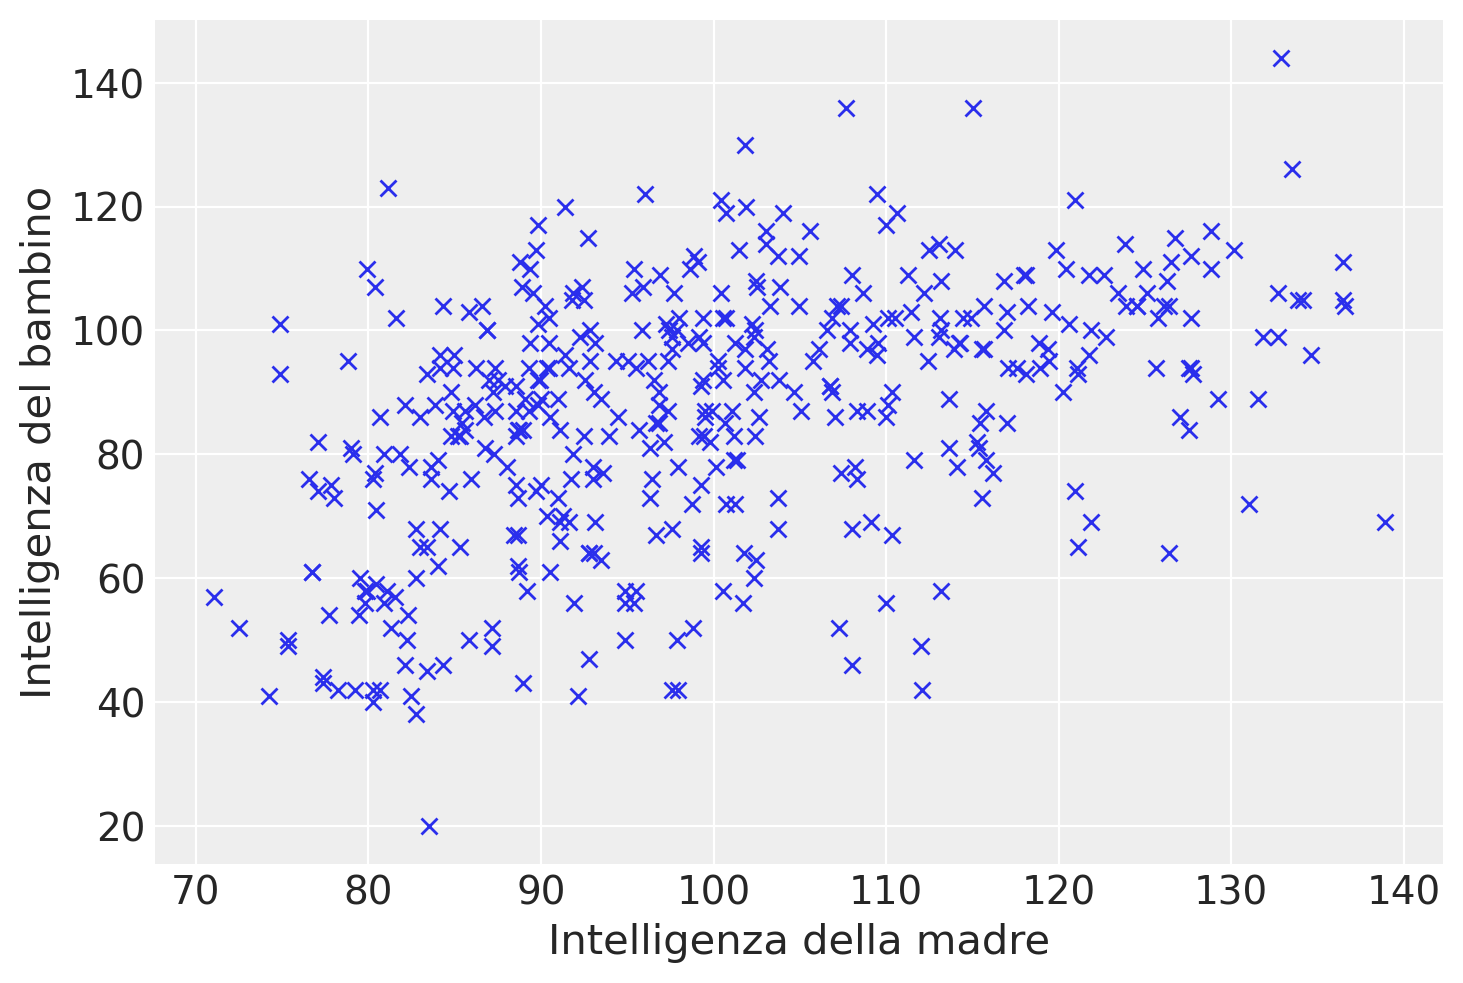

In [7]:
plt.plot(x, y, "x")
plt.xlabel("Intelligenza della madre")
_ = plt.ylabel("Intelligenza del bambino")

Calcoliamo i coefficienti del modello 

$$
y_i = \beta_0 + \beta_1 x_i + e_i
$$

con il metodo della massima verosimiglianza. A questo scopo usiamo la funzione `linear_regression()` del pacchetto `pingouin`.

In [8]:
lm = pg.linear_regression(x, y)
lm.round(2)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,25.80,5.92,4.36,0.0,0.2,0.2,14.17,37.43
1,mom_iq,0.61,0.06,10.42,0.0,0.2,0.2,0.49,0.72


Recuperiamo i coefficienti `b0` e `b1` dall'oggetto `lm` creato da `linear_regression()`.

In [9]:
beta = lm["coef"]  # Coefficienti
beta

0    25.799778
1     0.609975
Name: coef, dtype: float64

In [10]:
b0 = beta[0]
b1 = beta[1]

Calcoliamo i valori predetti dal modello di regressione:

$$
\hat{y}_i = \beta_0 + \beta_1 x_i
$$

In [11]:
yhat = b0 + b1 * x
yhat

0      99.678390
1      80.308253
2      96.217173
3      86.461529
4      82.372303
         ...    
429    77.572841
430    82.521552
431    83.661788
432    84.879856
433    81.461993
Name: mom_iq, Length: 434, dtype: float64

I modelli predetti $\yhat$ corrispondono alla retta di regressione.

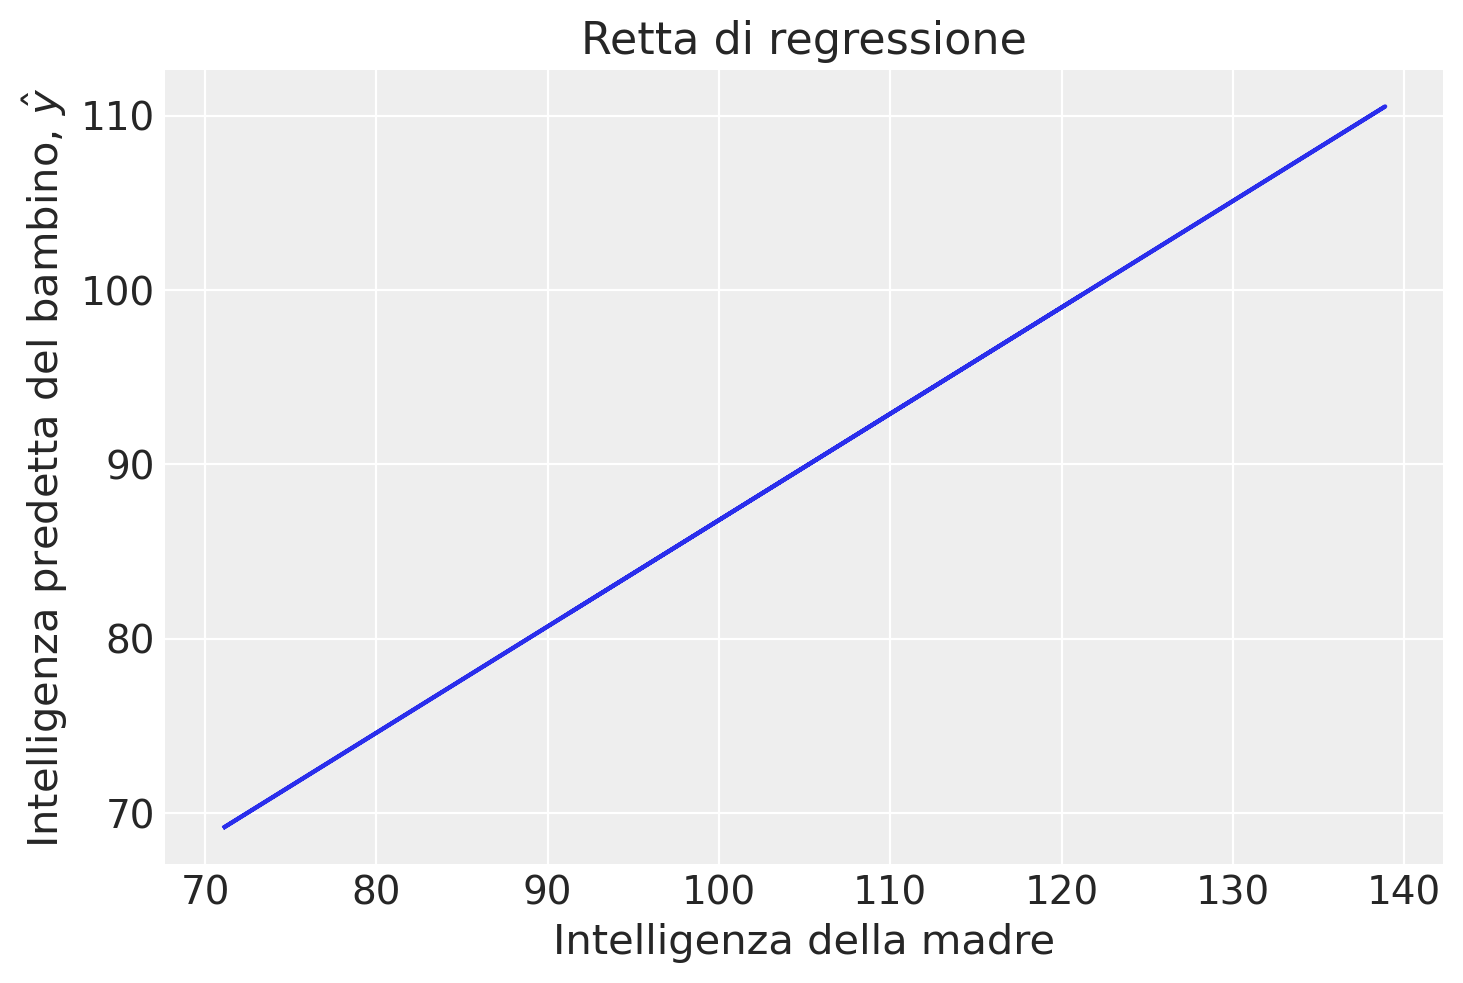

In [12]:
plt.plot(x, yhat)
plt.xlabel("Intelligenza della madre")
plt.ylabel("Intelligenza predetta del bambino, $\hat{y}$")
_ = plt.title("Retta di regressione")

Aggiungiamo i dati osservati al grafico.

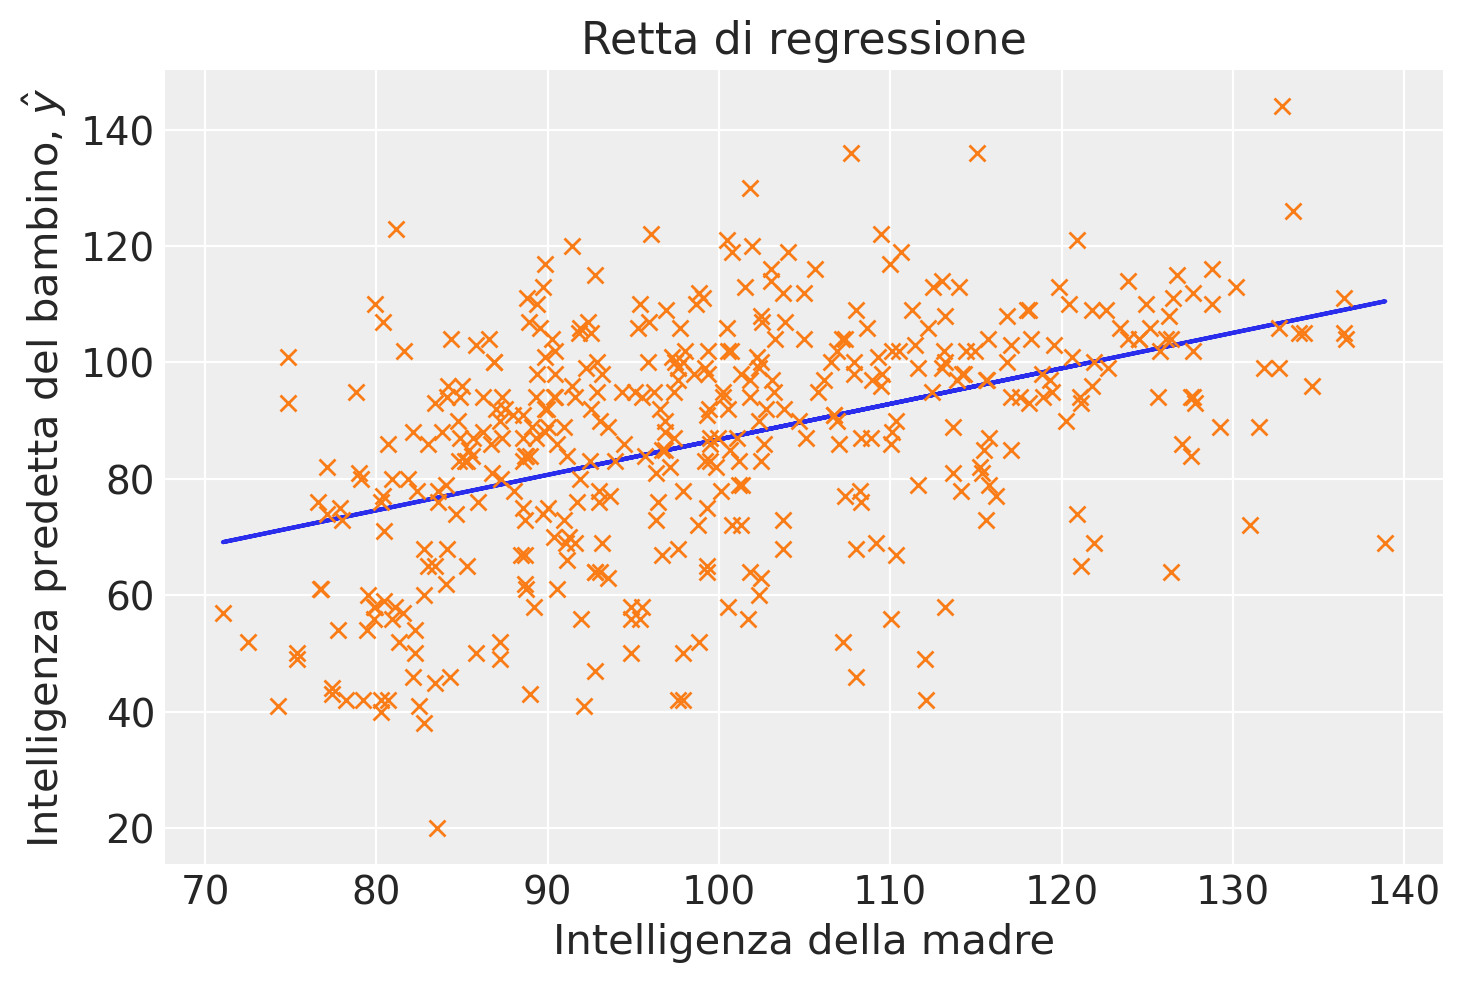

In [12]:
plt.plot(x, yhat)
plt.plot(x, y, "x")
plt.xlabel("Intelligenza della madre")
plt.ylabel("Intelligenza predetta del bambino, $\hat{y}$")
_ = plt.title("Retta di regressione")

### Interpretazione

Il coefficiente $\beta_0$ indica il valore atteso della distribuzione condizionata $p(y_i \mid x_i = 0)$. Nel caso presente, indica la media del quoziente d'intelligenza del bambino quando la madre ha un quoziente di intelligenza uguale a 0. Ovviamente questa non è un'informazione di una qualche importanza pratica. Vedremo come migliorare l'interpretabilità dell'intercetta usando una parametrizzazione alternativa dei dati.

Il coefficiente $\beta_1$ indica il cambiamento del valore atteso della variabile dipendente quando la variabile indipendente aumenta di un'unità. Nel caso presente abbiamo che il punteggio del quoziente di intelligenza del bambino aumenta in media di 0.61 punti quando il quoziente di intelligenza della madre aumenta di un punto. In una parametrizzazione alternativa, standardizzando la variabile indipendente, $\beta_1$ indicherebbe di quanto varia in media il quoziente di intelligenza del bambino quando il quoziente di intelligenza della madre aumenta di una deviazione standard.

## Residui

Calcoliamo i residui

$$
e_i = y_i - \hat{y}_i
$$

In [10]:
e = y - yhat

La retta di regressine calcolata con il metodo della massima verosimiglianza ha le seguenti proprietà:

- il valore atteso dei residui è zero,
- i residui sono incorrelati con i valori predetti.

Valutiamo la media dei residui:

In [11]:
np.mean(e)

-1.5455123100404022e-14

Calcoliamo la correlazione tra i residui $e$ e i valori predetti $\hat{y}$:

In [12]:
np.corrcoef(e, yhat)[0, 1]

1.6170164072555654e-16

Il modello di regressione bivariato 

$$
y_i = \beta_0 + \beta_1 x_i + e_i
$$

scompone la variabile dipendente $y_i$ in due componenti tra loro incorrelate, una componente deterministica

$$
\hat{y}_i = \beta_0 + \beta_1 x_i 
$$

e una componente aleatoria

$$
e_i = y_i - \hat{y}_i.
$$

In [21]:
df = pd.DataFrame()
df["x"] = x
df["y"] = y
df["yhat"] = yhat
df["e"] = e
df["sum"] = df["yhat"] + df["e"]
df

,x,y,yhat,e,sum
0,121.117529,65,99.678390,-34.678390,65.0
1,89.361882,98,80.308253,17.691747,98.0
2,115.443165,85,96.217173,-11.217173,85.0
3,99.449639,83,86.461529,-3.461529,83.0
4,92.745710,115,82.372303,32.627697,115.0
...,...,...,...,...,...
429,84.877412,94,77.572841,16.427159,94.0
430,92.990392,76,82.521552,-6.521552,76.0
431,94.859708,50,83.661788,-33.661788,50.0
432,96.856624,88,84.879856,3.120144,88.0


## Errore Standard della Regressione

L'errore standard della regressione rappresenta la stima della deviazione standard dei residui nell'intera popolazione. Questo parametro può essere calcolato attraverso la formula:

$$
\hat{\sigma}_e = \sqrt{\frac{\sum_i (e_i - \bar{e})^2}{n-2}},
$$

dove $ \bar{e} $ indica la media dei residui, che teoricamente è zero dato che si assume che la media degli errori sia zero.

Il denominatore "n-2" deriva dalla perdita di due gradi di libertà, necessaria per la stima dei due coefficienti, $ \beta_0 $ (intercetta) e $ \beta_1 $ (pendenza), che sono utilizzati per calcolare le stime previste $ \hat{y}_i = \beta_0 + \beta_1 x_i $. Questi gradi di libertà vengono sottratti perché ciascun parametro stimato consuma un grado di libertà dal totale disponibile.

Nel caso dell'esempio, la numerosità campionaria è

In [15]:
n = len(x)
n

434

L'errore standard della regressione diventa

In [16]:
np.sqrt(np.sum(e**2) / (n-2))

18.266122792299274

Questo valore indica che, in media, nella popolazione la distanza tra i valori osservati e la retta di regressione è di 18.3 punti.

Come discusso da {cite}`gelman2020regression`, la radice quadrata media dei residui, $ \frac{1}{n} \sum_{i=1}^n (y_i - (\hat{a} + \hat{b}x_i))^2 $, tende a sottostimare la deviazione standard $\sigma$ dell'errore nel modello di regressione. Questa sottostima è spesso il risultato di un sovradimensionamento, dato che i parametri $a$ e $b$ sono stimati utilizzando gli stessi $n$ punti dati usati anche per calcolare i residui.

La validazione incrociata rappresenta un approccio alternativo per valutare l'errore predittivo che evita alcuni dei problemi legati al sovradimensionamento. La versione più semplice della validazione incrociata è l'approccio leave-one-out, in cui il modello è adattato $n$ volte, escludendo ogni volta un punto dati, adattando il modello ai rimanenti $n-1$ punti dati, e utilizzando questo modello adattato per predire l'osservazione esclusa:
- Per $i = 1, \ldots, n$:
  - Adatta il modello $y = a + bx + \text{errore}$ ai $n-1$ punti dati $(x,y)_j, j \neq i$. Denomina i coefficienti di regressione stimati come $\hat{a}_{-i}, \hat{b}_{-i}$.
  - Calcola il residuo validato incrociato, $ r_{\text{CV}} = y_i - (\hat{a}_{-i} + \hat{b}_{-i} x_i) $.
  - Calcola la stima di $\sigma_{\text{CV}} = \frac{1}{n} \sum_{i=1}^n r_{\text{CV}}^2$.

Per fare un esempio, eseguiamo i passaggi sopra descritti per il modello dell'intelligenza del bambino predetta dall'intelligenza della madre. 

In [24]:
# Inizializzazione di un modello di regressione lineare
model = LinearRegression()

# Array per salvare i residui cross-validated
residuals_cv = []

# Loop per la validazione incrociata leave-one-out
for i in range(len(df)):
    # Dati di training escludendo l'i-esimo punto
    X_train = df.loc[df.index != i, ["x"]]
    y_train = df.loc[df.index != i, "y"]

    # Dati di test
    X_test = df.loc[[i], ["x"]]
    y_test = df.loc[i, "y"]

    # Addestramento del modello
    model.fit(X_train, y_train)

    # Predizione sull'i-esimo punto
    y_pred = model.predict(X_test)

    # Calcolo del residuo validato incrociato
    residual_cv = y_test - y_pred[0]
    residuals_cv.append(residual_cv**2)

# Calcolo di sigma_cv
sigma_cv = np.sqrt(np.mean(residuals_cv))

print("Stima di σ_CV:", sigma_cv)

Stima di σ_CV: 18.306662828465665


Nel caso dei dati analizzati, si osserva che la stima ottenuta attraverso la validazione incrociata è leggermente superiore rispetto a quella calcolata usando la formula 
$
\hat{\sigma}_e = \sqrt{\frac{\sum_i (e_i - \bar{e})^2}{n-2}}
$.
Questo incremento, sebbene minimo, riflette le differenze metodologiche tra i due approcci di stima dell'errore standard.

## Parametrizzazione Alternativa

Per consentire una migliore interpretazione dell'intercetta, centriamo i valori della variabile indipendente.

In [24]:
xc = x - np.mean(x)
np.mean(xc)

7.858537169696961e-16

Eseguiamo l'analisi di regressione.

In [25]:
lm2 = pg.linear_regression(xc, y)
lm2.round(2)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,86.80,0.88,98.99,0.0,0.2,0.2,85.07,88.52
1,mom_iq,0.61,0.06,10.42,0.0,0.2,0.2,0.49,0.72


Notiamo che la stima della pendenza della retta di regressione è rimasta immutata, mentre cambia il coefficiente $\beta_0$. Nel caso in cui la variabile indipendente sia centrata, il coefficiente $\beta_0$ rappresenta il valore atteso della variabile dipendente quando la variabile indipendente assume il suo valore medio.

Nel caso presente, il valore 86.80 indica la media del quoziente di intelligenza del bambino quando il quoziente di intelligenza della madre assume il valore medio nel campione.

Adesso standardizziamo sia la variabile dipendente che la variabile indipendente.

In [28]:
x_mean = np.mean(x)
x_std = np.std(x, ddof=0)

# Standardizzazione
zx = (x - x_mean) / x_std

print(np.mean(zx), np.std(zx))

4.9115857310606007e-17 0.9999999999999999


In [27]:
y_mean = np.mean(y)
y_std = np.std(y, ddof=0)

# Standardizzazione
zy = (y - y_mean) / y_std

In [29]:
lm3 = pg.linear_regression(zx, zy)
lm3.round(2)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,-0.00,0.04,-0.00,1.0,0.2,0.2,-0.08,0.08
1,mom_iq,0.45,0.04,10.42,0.0,0.2,0.2,0.36,0.53


Dopo aver standardizzato entrambe le variabili, i coefficienti di regressione possono essere interpretati nel seguente modo:

- **$\beta_0$ = 0**: Questo si verifica perché la retta di regressione, calcolata attraverso il metodo dei minimi quadrati (ML), interseca il punto delle medie delle variabili standardizzate, ovvero $(\bar{X}, \bar{Y})$.
- **$\beta_1$**: Rappresenta la variazione media della variabile dipendente, espressa in termini di deviazioni standard, per ogni aumento di una deviazione standard nella variabile indipendente.

## Teorema della scomposizione della devianza

Il teorema della scomposizione della devianza nel modello di regressione lineare ci aiuta a comprendere quanto bene il modello si adatta ai dati. Esso scompone la variazione totale dei dati in componenti attribuibili all'effetto del modello e alla variazione residua non spiegata dal modello. 

### Formulazione del Teorema

Dato un set di dati $ y_1, y_2, \dots, y_n $, dove $ y_i $ rappresenta l'i-esimo valore della variabile dipendente, e $ \bar{y} $ è la media campionaria di $ y $, la devianza totale (o variazione totale) dei dati può essere scomposta nel seguente modo:

1. **Devianza Totale (VT)**: Misura la dispersione totale dei dati intorno alla loro media.
   $$
   DT = \sum_{i=1}^n (y_i - \bar{y})^2
   $$

2. **Devianza Spiegata (VS)**: Misura quanto della variazione totale è spiegata dal modello di regressione.
   $$
   DS = \sum_{i=1}^n (\hat{y}_i - \bar{y})^2
   $$
   dove $ \hat{y}_i $ è il valore predetto dalla regressione per l'i-esimo osservazione.

3. **Devianza Residua (VR)**: Misura la variazione dei dati che il modello non riesce a spiegare.
   $$
   DR = \sum_{i=1}^n (y_i - \hat{y}_i)^2
   $$

### Teorema di Scomposizione della Devianza

Il teorema afferma che la variazione totale $ DT $ è uguale alla somma della variazione spiegata $ DS $ e della variazione residua $ DR $:

$$
DT = DS + DR
$$

### Dimostrazione

La dimostrazione di questa identità si basa sul principio di ortogonalità dei residui e delle stime. I residui $ y_i - \hat{y}_i $ sono ortogonali alle predizioni $ \hat{y}_i - \bar{y} $ nel contesto della regressione lineare. Matematicamente, ciò è espresso da:

$$
\sum_{i=1}^n (\hat{y}_i - \bar{y})(y_i - \hat{y}_i) = 0
$$

Utilizzando l'ortogonalità, possiamo scrivere la variazione totale come segue:

$$
\begin{align*}
DT &= \sum_{i=1}^n (y_i - \bar{y})^2 \\
   &= \sum_{i=1}^n [(y_i - \hat{y}_i) + (\hat{y}_i - \bar{y})]^2 \\
   &= \sum_{i=1}^n (y_i - \hat{y}_i)^2 + 2\sum_{i=1}^n (y_i - \hat{y}_i)(\hat{y}_i - \bar{y}) + \sum_{i=1}^n (\hat{y}_i - \bar{y})^2 \\
   &= DR + 2 \cdot 0 + DS \\
   &= DR + DS
\end{align*}
$$

Questa dimostrazione chiarisce che la variazione totale è esattamente uguale alla somma della devianza spiegata dal modello e quella non spiegata (residua). Il coefficiente di determinazione $ R^2 $, che è definito come $ R^2 = \frac{DS}{DT} $, offre una misura della proporzione della variazione totale spiegata dal modello.

Applichiamo ora il teorema di scomposizione della devianza ai dati in esame. Usando `pg.linear_regression(x, y)` calcoliamo il coefficiente di determinazione.

In [17]:
r_squared = lm["r2"][0] # R-squared del modello
print(r_squared)

0.20095123075855126


Calcoliamo la devianza totale.

In [18]:
DT = np.sum((y - np.mean(y))**2)
print(DT)

180386.15668202768


Calcoliamo la devianza spiegata.

In [19]:
DS = np.sum((yhat - np.mean(y)) ** 2)
print(DS)

36248.82019705826


Calcoliamo la devianza residua.

In [20]:
DR = np.sum((y - yhat) ** 2)
print(DR)

144137.33648496936


La devianza totale è la somma della devianza spiegata e della devianza residua.

In [21]:
DS + DR

180386.15668202762

Il coefficiente di determinazione è il rapporto tra la devianza spiegata e la devianza totale.

In [22]:
Rsq = DS / DT
print(Rsq)

0.2009512307585509


## Inferenza

Esistono due principali approcci di inferenza statistica applicabili ai modelli di regressione: l'inferenza frequentista e l'inferenza bayesiana.

### Inferenza Frequentista
L'inferenza frequentista stabilisce le sue basi analizzando la distribuzione campionaria delle stime dei coefficienti di regressione e calcolando l'errore standard associato. Questo metodo si focalizza prevalentemente sul test delle ipotesi e sulla costruzione degli intervalli di fiducia. Tuttavia, il test dell'ipotesi nulla è spesso criticato nel dibattito metodologico contemporaneo per la sua rigidezza e limitazioni interpretative. Analogamente, gli intervalli di fiducia possono risultare contro-intuitivi e di limitata utilità pratica, dato che richiedono un'interpretazione che non riflette direttamente la probabilità che il parametro si trovi all'interno dell'intervallo specificato.

### Inferenza Bayesiana
Contrariamente all'approccio frequentista, l'inferenza bayesiana offre un quadro più flessibile e intuitivo per l'analisi statistica. Attraverso l'utilizzo degli intervalli di credibilità, l'inferenza bayesiana permette di incorporare conoscenze pregresse e aggiornarle alla luce di nuovi dati. Gli intervalli di credibilità forniscono una stima diretta della probabilità che un parametro si trovi all'interno di un certo intervallo, basata sulla distribuzione a posteriori. Questo rende l'interpretazione più diretta e gli intervalli di credibilità risultano essere strumenti praticamente più utili nell'inferenza statistica.

Per queste ragioni, molti ricercatori e analisti preferiscono sviluppare inferenze tramite l'approccio bayesiano, specialmente quando le situazioni richiedono una maggiore flessibilità interpretativa e l'integrazione di informazioni pregresse nel modello analitico.

## Informazioni sull'Ambiente di Sviluppo

In [13]:
%load_ext watermark
%watermark -n -u -v -iv -w -m 

Last updated: Wed May 22 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.24.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

scipy     : 1.13.0
numpy     : 1.26.4
seaborn   : 0.13.2
pandas    : 2.2.2
matplotlib: 3.8.4
arviz     : 0.18.0
pingouin  : 0.5.4

Watermark: 2.4.3

